In [1]:
# !git clone https://github.com/analokmaus/kuma_utils.git

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import sys; sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
# config.gpu_options.per_process_gpu_memory_fraction = fraction
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
dataset_path = "./dataset"

df = pd.read_csv(f'{dataset_path}/train.csv')
test = pd.read_csv(f'{dataset_path}/test.csv')
sub = pd.read_csv(f'{dataset_path}/sample_submission.csv')

### Checking Missing values
1. The train data consists 20273 missing values while test data has 15709 missing values.
2. Feature measurement_17 has the highest number of missing values.
3. Overall both train and test dataset has same ratio of missing values as can be observed in plot below.

                train_missing  test_missing
id                        0.0           0.0
product_code              0.0           0.0
loading                 250.0         223.0
attribute_0               0.0           0.0
attribute_1               0.0           0.0
attribute_2               0.0           0.0
attribute_3               0.0           0.0
measurement_0             0.0           0.0
measurement_1             0.0           0.0
measurement_2             0.0           0.0
measurement_3           381.0         329.0
measurement_4           538.0         409.0
measurement_5           676.0         508.0
measurement_6           796.0         624.0
measurement_7           937.0         720.0
measurement_8          1048.0         846.0
measurement_9          1227.0         904.0
measurement_10         1300.0        1067.0
measurement_11         1468.0        1136.0
measurement_12         1601.0        1240.0
measurement_13         1774.0        1303.0
measurement_14         1874.0   

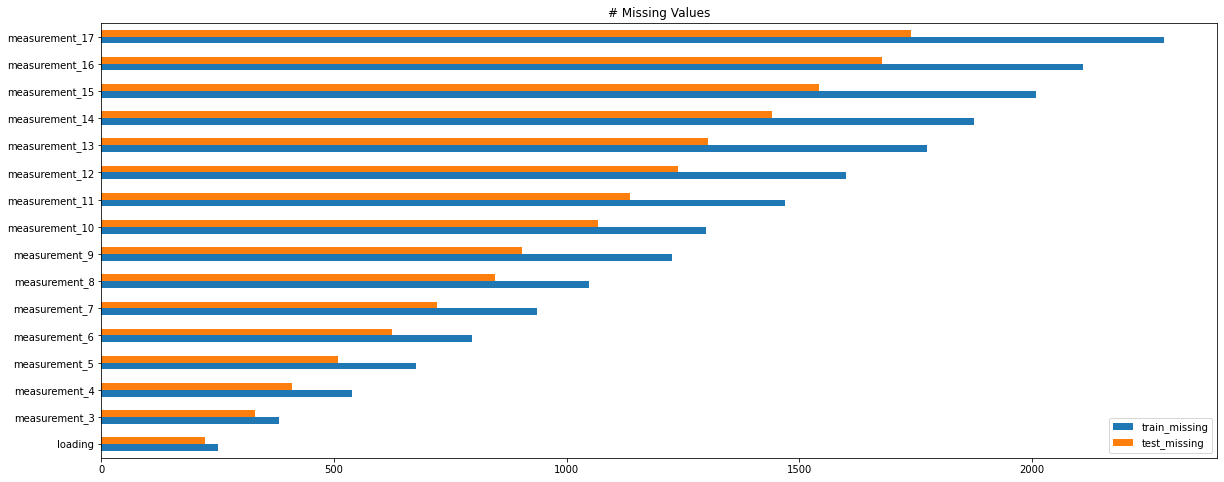

In [5]:
train = df.copy()
ncounts = pd.DataFrame([train.isna().sum(), test.isna().sum()]).T
ncounts = ncounts.rename(columns={0: "train_missing", 1: "test_missing"})
print(ncounts)

ncounts.query("train_missing > 0").plot(kind="barh", figsize=(20, 8), title="# Missing Values")
plt.show()

### Feature Distributions Of Training Data
Features product_code and all 3 attribute_[0,..,3] features are categorical.

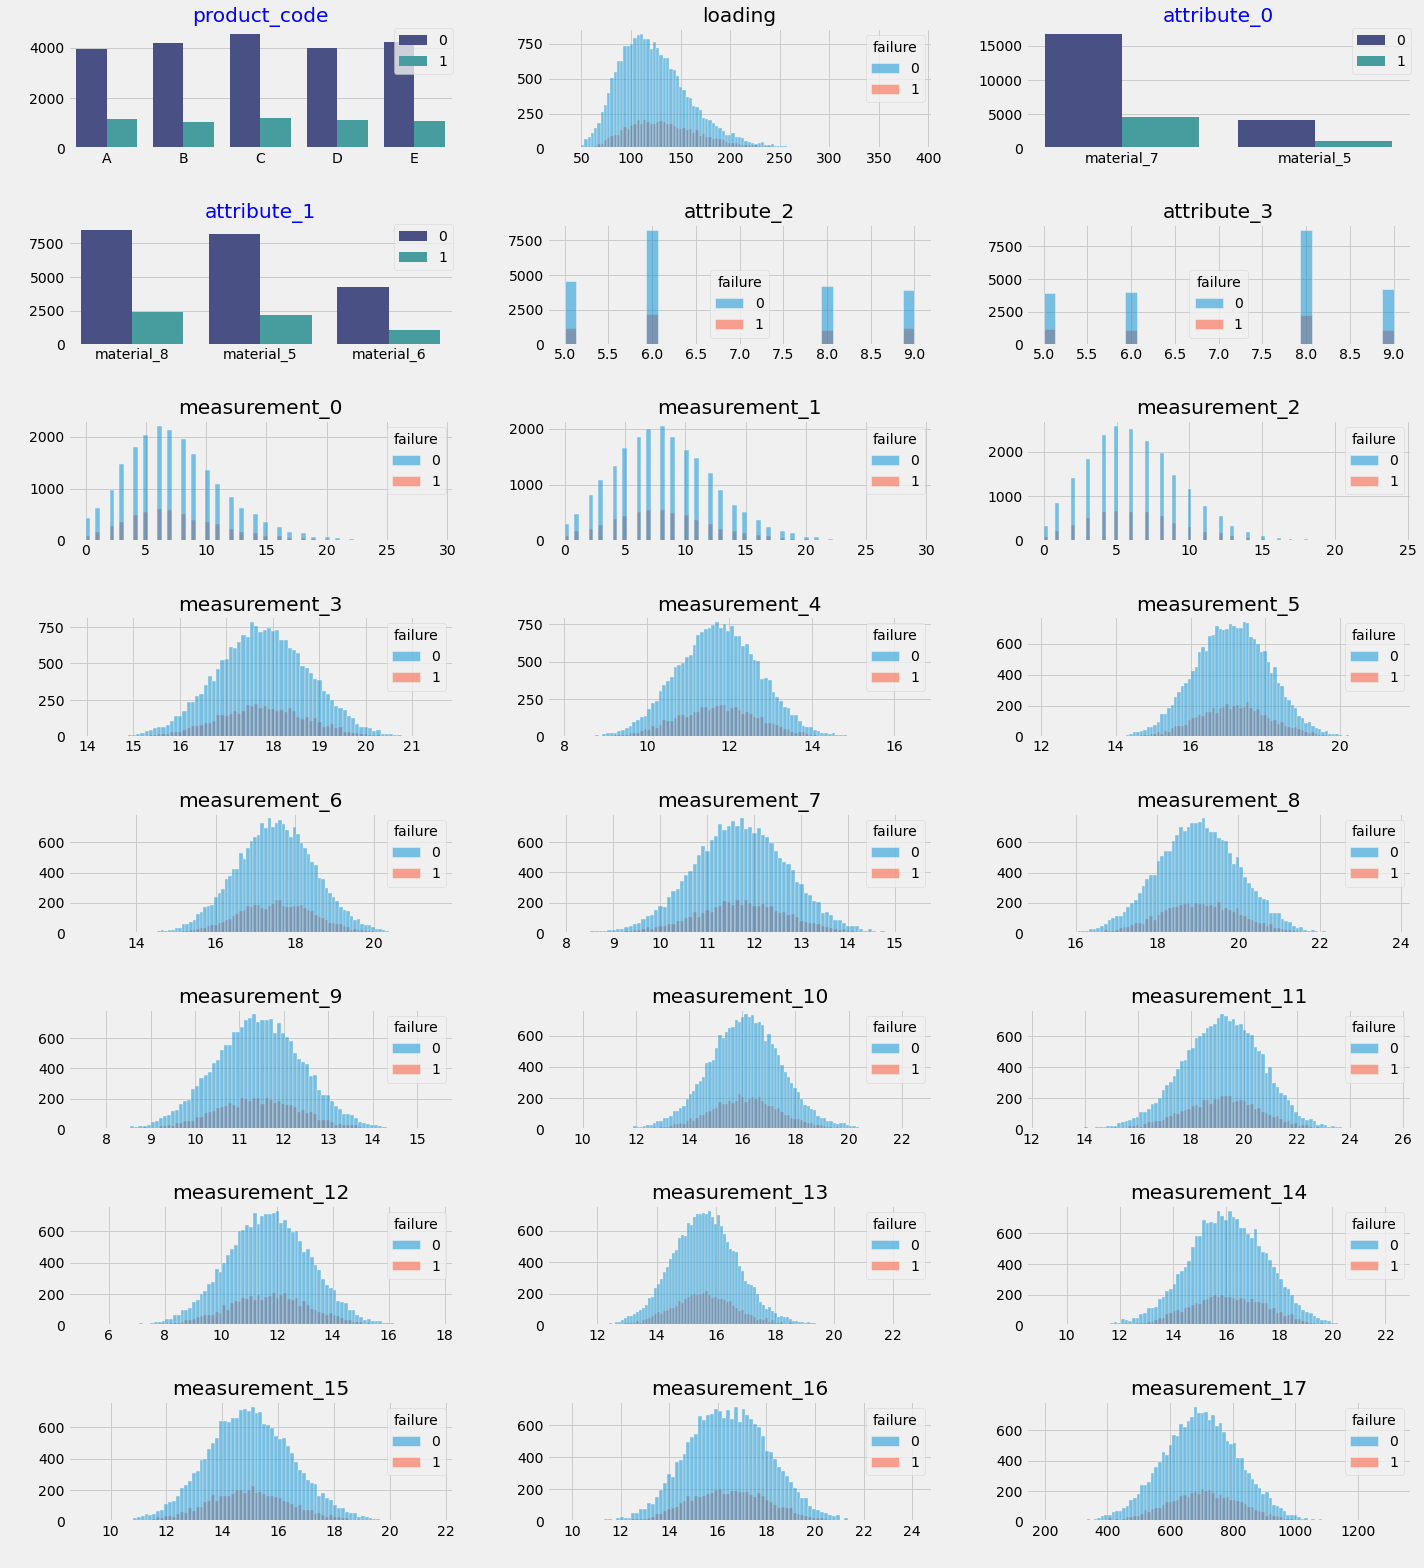

In [6]:
plt.style.use("fivethirtyeight")
useful_cols=[col for col in df.columns if col not in ["id","failure"]]
cols_dist = [col for col in useful_cols if df[col].dtypes not in ['object']]
color_ = [ '#9D2417', '#AF41B4', '#003389' ,'#3C5F41',  '#967032', '#2734DE'] 
cmap_ = ['mako', 'rainbow', 'crest']

plt.figure(figsize= (20,22))
for i,col in enumerate(train[useful_cols].columns):
    rand_col = color_[random.sample(range(6), 1)[0]]
    plt.subplot(8,3, i+1)
    if col in cols_dist:        
        sns.histplot(data=train,x=train[col],hue=train['failure'], color = rand_col, fill = rand_col)
        plt.title(col, color = 'black')
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.tight_layout()
    else:
        sns.countplot(data = train , x = col, hue=train['failure'], palette = cmap_[random.sample(range(3), 1)[0]] )
        plt.title(col, color = 'blue')
        plt.ylabel(" ")
        plt.xlabel(" ")
        plt.legend(loc='upper right', borderaxespad=0)
        plt.tight_layout()

### Loading Feature
The loading feature seems to have right skewed distribution.

Applying log transformation seems to make the distribution more normal.

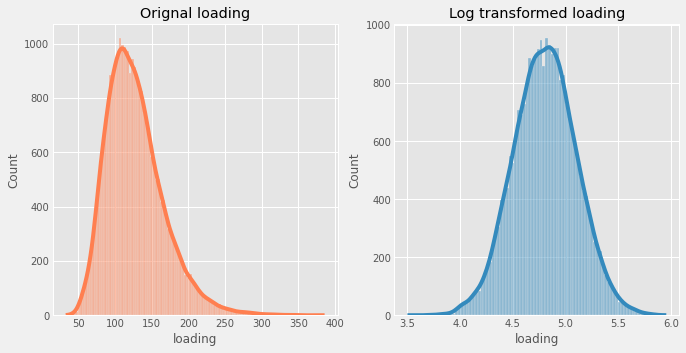

In [7]:
plt.figure(figsize= (10,5))
plt.style.use('ggplot')
plt.subplot(1,2,1)
sns.histplot(train['loading'],kde=True,color='coral')
plt.title("Orignal loading")
plt.subplot(1,2,2)
sns.histplot(np.log(train["loading"]),kde=True)
plt.title("Log transformed loading")
plt.show()

### Product Code
The data seems to be pivoted/revolving around the product_code feature.

We can observe from the plot below that the data belonging to product_code "C" seems to have more number of missing values for most of the features.

For imputing missing values in data we can apply an imputer by grouping data on product code.

['A' 'B' 'C' 'D' 'E']


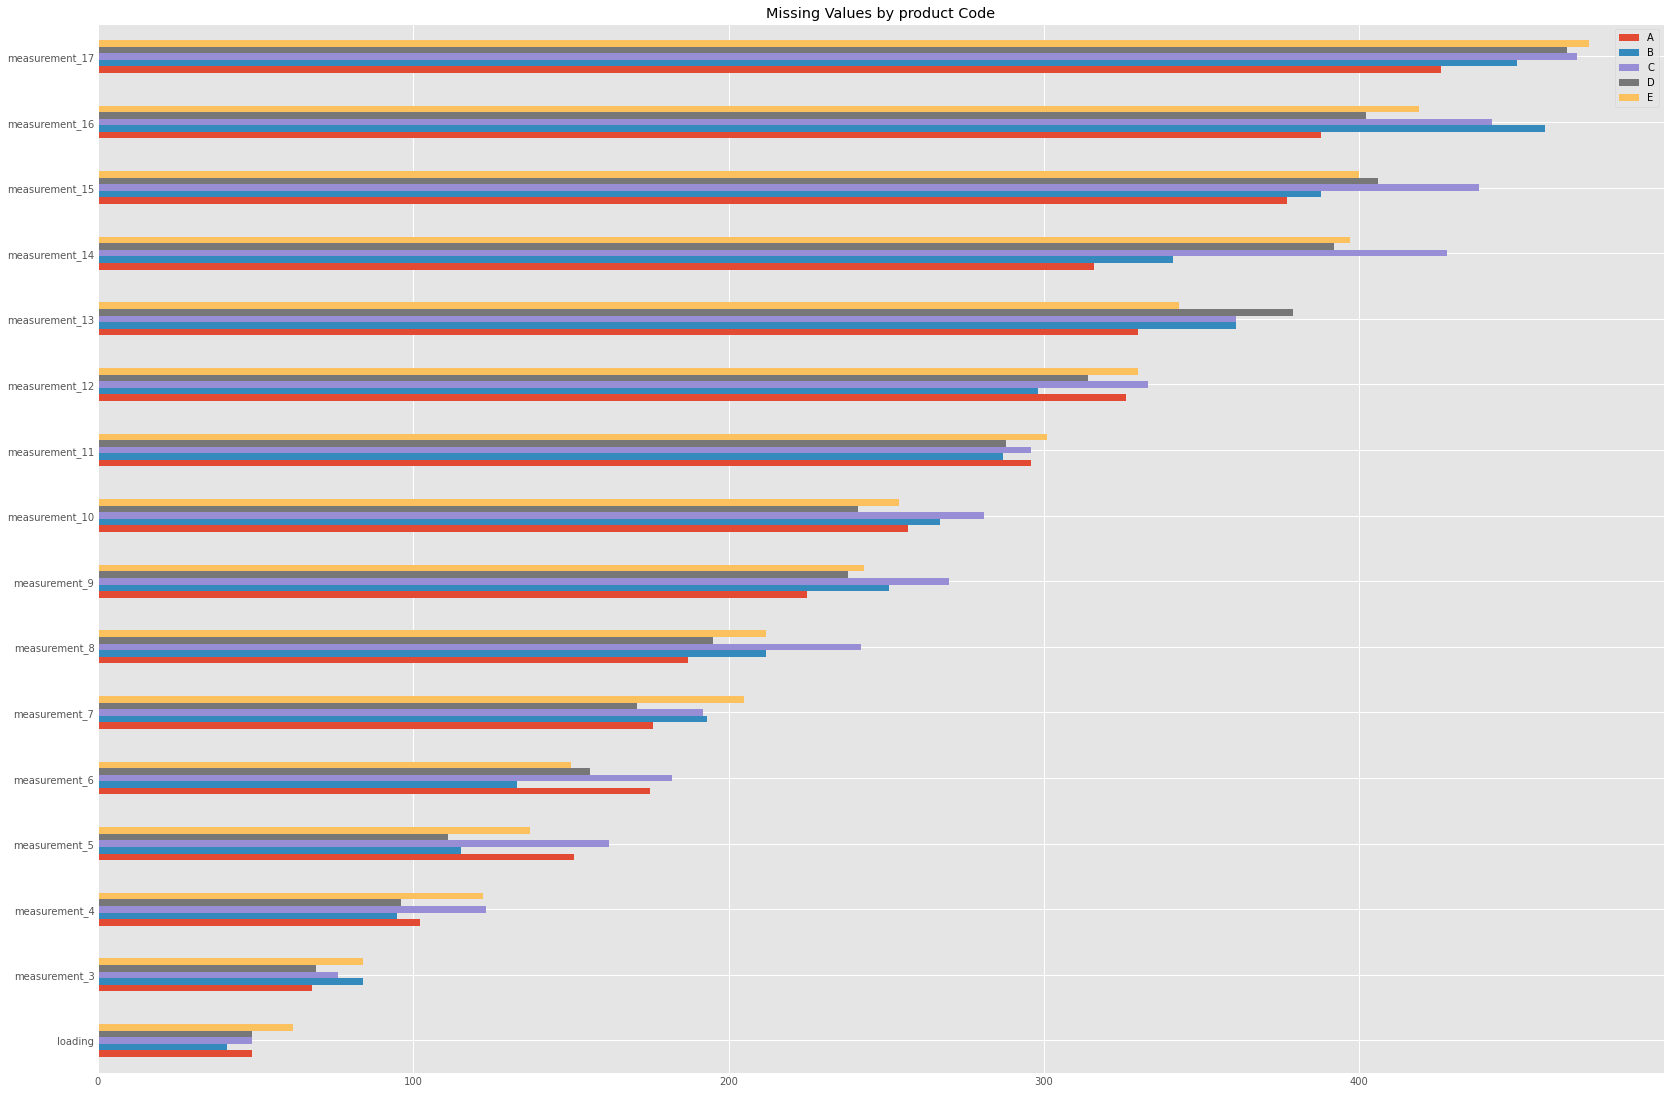

In [8]:
pc=df.product_code.unique()
print(pc)
comp=pd.DataFrame([df[df.product_code==i].isna().sum() for i in pc]).T
comp.columns=pc
comp.query('A>0').plot(kind="barh", figsize=(25, 18), title="Missing Values by product Code")
plt.show()

In [9]:
y=df.failure
X=df.drop('failure',axis=1)

### Imputing missing values by LGBM imputer
I will impute missing values for each product of product_code from both train and test data.

In [10]:
null_cols=[col for col in train.columns if train[col].isnull().sum()!=0]
non_null=[col for col in X.columns if col not in null_cols]
cat=[col for col in X.columns if X[col].dtypes == 'object']
prd_code=df.product_code.unique() # unique product_code of train data
tst_prd_code=test.product_code.unique() # unique product_code of test data

print(null_cols)
print("=========")
print(non_null)
print("=========")
print(cat)
print("=========")
print(prd_code)
print("=========")
print(tst_prd_code)

['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
['id', 'product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2']
['product_code', 'attribute_0', 'attribute_1']
['A' 'B' 'C' 'D' 'E']
['F' 'G' 'H' 'I']


In [11]:
tf.config.threading.set_intra_op_parallelism_threads(6)

In [ ]:
lgbm_imtr = LGBMImputer(cat_features=cat, n_iter=50) 
tr=pd.DataFrame()
for pc in prd_code: #looping through product_code
    tr=pd.concat([tr,lgbm_imtr.fit_transform(X[X['product_code']==pc][null_cols])],axis=0) #imputing values for each product_code and appending them to dataframe
tr=pd.concat([tr,X[non_null]],axis=1) 

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
print(tr.head())
print("==================")
print(X[tr.columns].head())

In [ ]:
ts=pd.DataFrame()
for pc in tst_prd_code:
    ts=pd.concat([ts,lgbm_imtr.fit_transform(test[test['product_code']==pc][null_cols])],axis=0)#imputing values for each product_code and appending them to dataframe
ts=pd.concat([ts,test[non_null]],axis=1)  

### Feature Engineering
ambrosm suggested in his [notebook](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense) that feature measurement_3 has lower failure rate than average failure rate and measurement_5 has higher failure rate than average failure rate so it can be inferred that availability or unavailability of these features is directly correlated with the failure so we can add availablity of these two features as new features.

In [ ]:
tr['m_3_missing']=X.measurement_3.isna().astype(int)
tr['m_5_missing']=X.measurement_5.isna().astype(int)

ts['m_3_missing']=test.measurement_3.isna().astype(int)
ts['m_5_missing']=test.measurement_5.isna().astype(int)

In [ ]:
print(ts)

### Label Encoding categorical features
All attribute features needs to be label encoded.

In [ ]:
cat_pr=[f'attribute_{i}' for i in range(4)]
for column in cat_pr:
    label_encoder = LabelEncoder()
    label_encoder.fit(tr[column].append(ts[column]))
    tr[column] = label_encoder.transform(tr[column])
    ts[column] = label_encoder.transform(ts[column])

In [ ]:
print(ts)

In [ ]:
cols_to_use=[col for col in tr.columns if col!='product_code']
print(cols_to_use)

### Scaling Data
Scaling entire data by using sklearn's Standard Scaler

In [ ]:
scaler = StandardScaler()
training=scaler.fit_transform(tr[cols_to_use])
testing=scaler.fit_transform(ts[cols_to_use])

In [ ]:
print(testing)

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(training,y,random_state=28,shuffle=True,test_size=0.2)

### Neural Network Baseline Model

In [8]:
tf.random.set_seed(42)
model_14 = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") 
])
early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=15,restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3 ,patience=4)
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/10))

model_14.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(lr=0.0007),
                 metrics=["AUC"])
print(model_14.summary())
# history = model_14.fit(X_train,
#                        y_train,
#                        epochs=200,
#                        callbacks=[early_stopping],
#                        validation_data=(X_test, y_test))

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
preds=model_14.predict(testing)
preds=preds.reshape(20775,)

In [ ]:
submission = pd.DataFrame({'id': sub.id,'failure': preds})
submission.to_csv('submission.csv', index=False)
submission